In [1]:
# Imports

########################################################################
# Python Standard Libraries
import os

########################################################################
# Numpy Library
import numpy as np # linear algebra

########################################################################
# Pandas Library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

########################################################################
# MATPLOT Library
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
%matplotlib inline

########################################################################
# SKLearn Library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc, multilabel_confusion_matrix

########################################################################
# SCIPY Library
from scipy.stats import gaussian_kde
import scipy.stats as st

In [2]:
def normalize(X, x_min=0, x_max=1):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom

class BilinearMap:
    def __init__(self, target_n):
        self.target_cols = target_n

    def compute_coeff(self, X, y):
        try:
            #assert False, 'deliberate'
            Xt = np.transpose(X)
            #print ('X.shape:', X.shape, 'Xt.shape:', Xt.shape)
            Xp = np.dot(Xt, X)
            #print ('Xp.shape:', Xp.shape)
            Xpi = np.linalg.inv(Xp)
            #print ('Xpi.shape:', Xpi.shape)
            XpiXt = np.dot(Xpi, Xt)
            #print ('XpiXt.shape:', XpiXt.shape)
            coeff = np.dot(XpiXt, y)
            print ('coeff.shape:', coeff.shape)
        except Exception as e:
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            coeff = regressor.coef_
            print ('Exception:', e)

        #coeff = normalize(coeff)
        return coeff

    def fit_transform(self, X, y):
        target_rows = X.shape[1]
        actual_rows = X.shape[0]
        required_rows = target_rows * self.target_cols

        if actual_rows < required_rows:
            assert False, f"{required_rows} rows are required, {actual_rows} are provided"

        Y = []
        for i in range(self.target_cols):
            start = i * target_rows
            end = start + target_rows
            coeff = self.compute_coeff(X[start:end,:], y[start:end])
            Y.extend(coeff.tolist())
            print("coeff.shape:", coeff.shape, "Len y:", len(Y), 'Start:', start, 'End:', end)
        Y = np.array(Y)
        Y = Y.reshape(target_rows, self.target_cols)
        print("Y.shape:", Y.shape)
        Z = np.dot(X, Y)
        return Z

In [3]:
# Utility functions

########################################################################
# Walk through input files
def print_input_files():
    # Input data files are available in the "../input/" directory.
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

########################################################################
# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())

########################################################################
# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)

########################################################################
# Dataset related functions
ds_nbaiot = '/kaggle/input/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname(ds_nbaiot, f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    return (X, y)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data
#print_input_files()

In [4]:
#devices_data = get_nbaiot_devices_data()

In [5]:
def gen_teda_obj(observation, k=None, mean=None, var=None, ecc=None):
    teda = {}
    if not k:
        k = 1
        mean = observation
        var = 0
        ecc = 1
    else:
        if mean is None or var is None or ecc is None:
            assert False, 'mean, variance and ecc values are required'

    teda['k'] = k
    teda['observation'] = observation
    teda['mean'] = mean
    teda['var'] = var
    teda['eccentricity'] = ecc
    teda['typicality'] = 1.0 - ecc
    teda['norm_eccentricity'] = teda['eccentricity'] / 2.0
    teda['norm_typicality'] = teda['typicality'] / (k - 2.0)
    teda['outlier'] = 1.0 if teda['norm_eccentricity'] > (1.0 / k) else 0.0
    teda['normal'] = 1.0 if teda['outlier'] < 0.5 else 0.0
    teda['normal_bool'] = True if teda['normal'] > 0.5 else False
    teda['ecc_threshold'] = 1.0 / k

    return teda


def calc_teda_single(observation, teda = None):
    if not teda:
        teda = gen_teda_obj(observation)
    else:
        k = teda['k'] + 1.0
        mean = teda['mean']
        var = teda['var']

        # Calculate the running mean value
        mean =  (((k - 1)  / k) * mean) + ((1 / k) * observation)

        # Calculate the running mean value
        var = (((k - 1) / k) * var) + (1 / (k - 1)) * np.linalg.norm(observation - mean)

        # Calculate the running eccentricity value
        ecc = (1 / k) +  (np.linalg.norm(mean - observation) / (k * var))

        teda = gen_teda_obj(observation, k, mean, var, ecc)

    return teda

def calc_teda(X):
    teda = None
    teda_output = []
    rows = X.shape[0]
    for i in range(rows):
        teda = calc_teda_single(X[i,:], teda)
        teda_output.append(teda['normal'])

    return teda_output

def predict(X, X_norm, X_anom):
    teda_norm = None
    teda_anom = None
    y_pred = []
    rows = X.shape[0]
    rows_norm = X_norm.shape[0]
    rows_anom = X_anom.shape[0]
    for i in range(rows_norm):
        teda_norm = calc_teda_single(X_norm[i,:], teda_norm)

    for i in range(rows_anom):
        teda_anom = calc_teda_single(X_anom[i,:], teda_anom)

    for i in range(rows):
        teda_norm_tmp = calc_teda_single(X[i,:], teda_norm)
        teda_anom_tmp = calc_teda_single(X[i,:], teda_anom)
        
        if (teda_norm_tmp['normal_bool'] == True):
            y_pred.append(1.0)
            teda_norm = teda_norm_tmp
        else:
            y_pred.append(0.0)
            teda_anom = teda_anom_tmp

        '''
        if (teda_norm_tmp['normal_bool'] == True) and (teda_anom_tmp['normal_bool'] == False):
            y_pred.append(1.0)
            teda_norm = teda_norm_tmp

        elif (teda_norm_tmp['normal_bool'] == False) and (teda_anom_tmp['normal_bool'] == True):
            y_pred.append(0.0)
            teda_anom = teda_anom_tmp

        elif (teda_norm_tmp['normal_bool'] == True) and (teda_anom_tmp['normal_bool'] == True):
            y_pred.append(1.0)
            teda_norm = teda_norm_tmp

        elif (teda_norm_tmp['normal_bool'] == False) and (teda_anom_tmp['normal_bool'] == False):
            y_pred.append(0.0)
            teda_anom = teda_anom_tmp
        '''


    return(np.array(y_pred))

In [6]:
'''
for i in range(9):
    device_index = i
    device_id = device_index + 1
    device_name = dn_nbaiot[device_index]
    (X, y) = get_nbaiot_device_data(device_id)
    X_std = StandardScaler().fit_transform(X)
    y_pred = np.array(calc_teda(X_std))
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    acc = accuracy_score(y, y_pred)
    print("acc,tn,fp,fn,tp")
    print(f'{acc:.2f},{tn},{fp},{fn},{tp}')
    plt.figure(figsize=(20,2))
    plt.plot(y_pred, '.')
    plt.title(device_name)
    plt.xlabel('instance')
    plt.ylabel('normal')
    plt.show()
'''

'\nfor i in range(9):\n    device_index = i\n    device_id = device_index + 1\n    device_name = dn_nbaiot[device_index]\n    (X, y) = get_nbaiot_device_data(device_id)\n    X_std = StandardScaler().fit_transform(X)\n    y_pred = np.array(calc_teda(X_std))\n    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()\n    acc = accuracy_score(y, y_pred)\n    print("acc,tn,fp,fn,tp")\n    print(f\'{acc:.2f},{tn},{fp},{fn},{tp}\')\n    plt.figure(figsize=(20,2))\n    plt.plot(y_pred, \'.\')\n    plt.title(device_name)\n    plt.xlabel(\'instance\')\n    plt.ylabel(\'normal\')\n    plt.show()\n'

processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Danmini_Doorbell
acc,tn,fp,fn,tp
0.98,968750,0,18432,31116


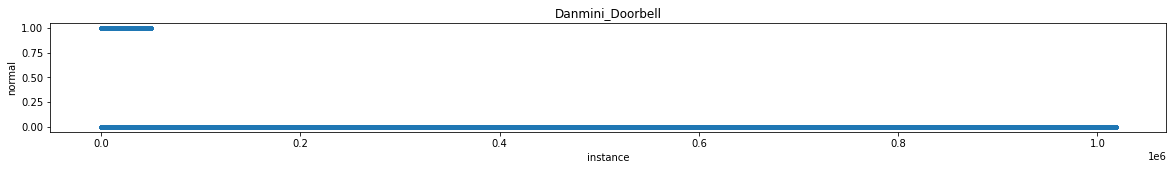

processing 2.benign.csv rows = 13113
processing 2.gafgyt.combo.csv rows = 53012
processing 2.gafgyt.junk.csv rows = 30312
processing 2.gafgyt.scan.csv rows = 27494
processing 2.gafgyt.tcp.csv rows = 95021
processing 2.gafgyt.udp.csv rows = 104791
processing 2.mirai.ack.csv rows = 113285
processing 2.mirai.scan.csv rows = 43192
processing 2.mirai.syn.csv rows = 116807
processing 2.mirai.udp.csv rows = 151481
processing 2.mirai.udpplain.csv rows = 87368


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Ecobee_Thermostat
acc,tn,fp,fn,tp
0.79,653342,169421,4915,8198


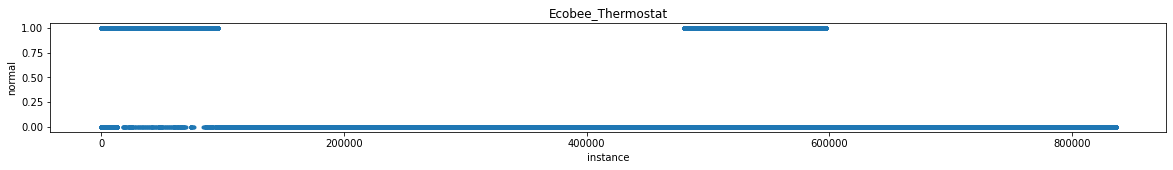

processing 3.benign.csv rows = 39100
processing 3.gafgyt.combo.csv rows = 53014
processing 3.gafgyt.junk.csv rows = 29797
processing 3.gafgyt.scan.csv rows = 28120
processing 3.gafgyt.tcp.csv rows = 101536
processing 3.gafgyt.udp.csv rows = 103933


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Ennio_Doorbell
acc,tn,fp,fn,tp
0.93,299971,16429,10143,28957


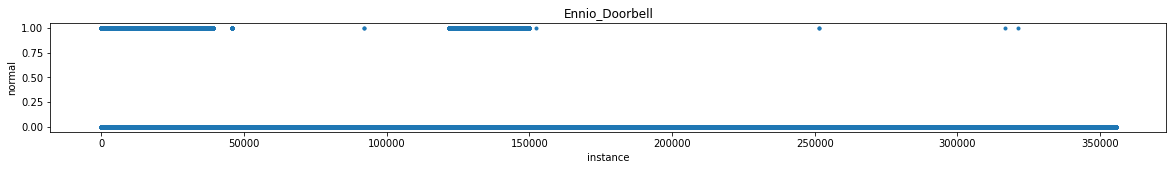

processing 4.benign.csv rows = 175240
processing 4.gafgyt.combo.csv rows = 58152
processing 4.gafgyt.junk.csv rows = 28349
processing 4.gafgyt.scan.csv rows = 27859
processing 4.gafgyt.tcp.csv rows = 92581
processing 4.gafgyt.udp.csv rows = 105782
processing 4.mirai.ack.csv rows = 91123
processing 4.mirai.scan.csv rows = 103621
processing 4.mirai.syn.csv rows = 118128
processing 4.mirai.udp.csv rows = 217034
processing 4.mirai.udpplain.csv rows = 80808


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Philips_B120N10_Baby_Monitor
acc,tn,fp,fn,tp
0.72,643594,279843,30860,144380


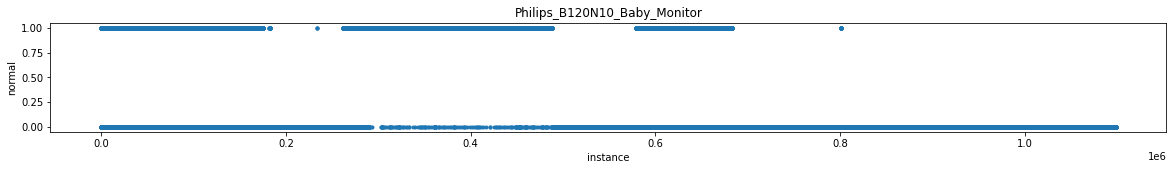

processing 5.benign.csv rows = 62154
processing 5.gafgyt.combo.csv rows = 61380
processing 5.gafgyt.junk.csv rows = 30898
processing 5.gafgyt.scan.csv rows = 29297
processing 5.gafgyt.tcp.csv rows = 104510
processing 5.gafgyt.udp.csv rows = 104011
processing 5.mirai.ack.csv rows = 60554
processing 5.mirai.scan.csv rows = 96781
processing 5.mirai.syn.csv rows = 65746
processing 5.mirai.udp.csv rows = 156248
processing 5.mirai.udpplain.csv rows = 56681


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Provision_PT_737E_Security_Camera
acc,tn,fp,fn,tp
0.70,539535,226571,20353,41801


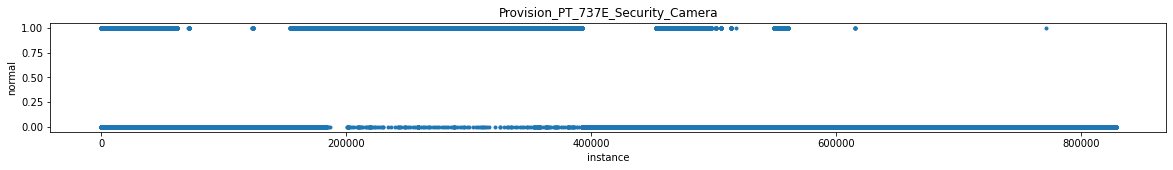

processing 6.benign.csv rows = 98514
processing 6.gafgyt.combo.csv rows = 57530
processing 6.gafgyt.junk.csv rows = 29068
processing 6.gafgyt.scan.csv rows = 28397
processing 6.gafgyt.tcp.csv rows = 89387
processing 6.gafgyt.udp.csv rows = 104658
processing 6.mirai.ack.csv rows = 57997
processing 6.mirai.scan.csv rows = 97096
processing 6.mirai.syn.csv rows = 61851
processing 6.mirai.udp.csv rows = 158608
processing 6.mirai.udpplain.csv rows = 53785


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Provision_PT_838_Security_Camera
acc,tn,fp,fn,tp
0.67,502713,235664,39392,59122


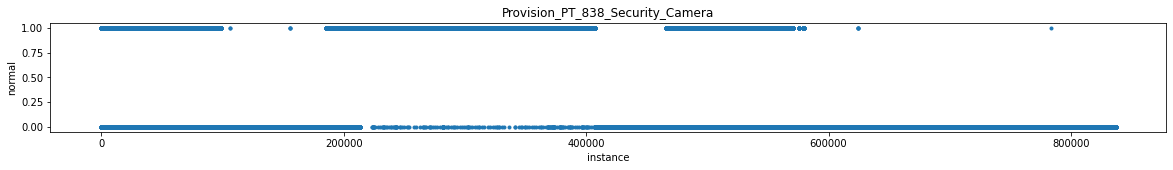

processing 7.benign.csv rows = 52150
processing 7.gafgyt.combo.csv rows = 58669
processing 7.gafgyt.junk.csv rows = 28305
processing 7.gafgyt.scan.csv rows = 27698
processing 7.gafgyt.tcp.csv rows = 97783
processing 7.gafgyt.udp.csv rows = 110617


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Samsung_SNH_1011_N_Webcam
acc,tn,fp,fn,tp
0.93,323072,0,25926,26224


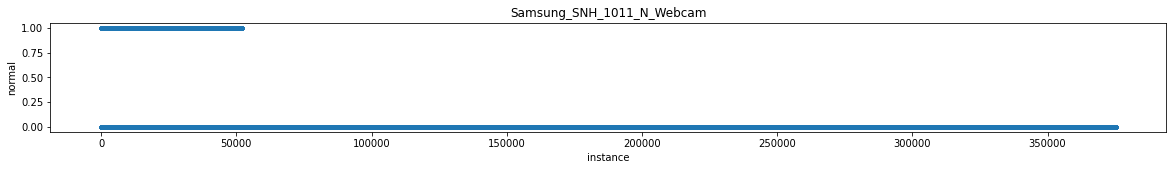

processing 8.benign.csv rows = 46585
processing 8.gafgyt.combo.csv rows = 54283
processing 8.gafgyt.junk.csv rows = 28579
processing 8.gafgyt.scan.csv rows = 27825
processing 8.gafgyt.tcp.csv rows = 88816
processing 8.gafgyt.udp.csv rows = 103720
processing 8.mirai.ack.csv rows = 111480
processing 8.mirai.scan.csv rows = 45930
processing 8.mirai.syn.csv rows = 125715
processing 8.mirai.udp.csv rows = 151879
processing 8.mirai.udpplain.csv rows = 78244


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


SimpleHome_XCS7_1002_WHT_Security_Camera
acc,tn,fp,fn,tp
0.70,569273,247198,7887,38698


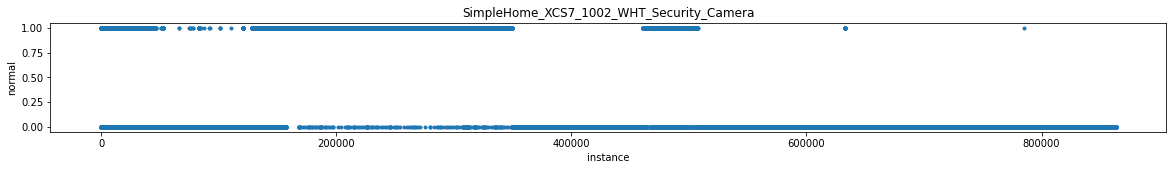

processing 9.benign.csv rows = 19528
processing 9.gafgyt.combo.csv rows = 59398
processing 9.gafgyt.junk.csv rows = 27413
processing 9.gafgyt.scan.csv rows = 28572
processing 9.gafgyt.tcp.csv rows = 98075
processing 9.gafgyt.udp.csv rows = 102980
processing 9.mirai.ack.csv rows = 107187
processing 9.mirai.scan.csv rows = 43674
processing 9.mirai.syn.csv rows = 122479
processing 9.mirai.udp.csv rows = 157084
processing 9.mirai.udpplain.csv rows = 84436


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


SimpleHome_XCS7_1003_WHT_Security_Camera
acc,tn,fp,fn,tp
0.72,595591,235707,1697,17831


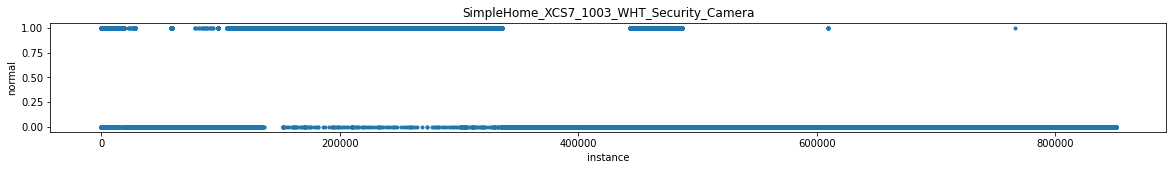

In [7]:
for i in range(9):
    device_index = i
    device_id = device_index + 1
    device_name = dn_nbaiot[device_index]
    (X, y) = get_nbaiot_device_data(device_id)
    X_std = StandardScaler().fit_transform(X)
    indices_norm = np.where(y >= 0.5)
    indices_anom = np.where(y <= 0.5)
    X_norm = X_std[indices_norm]
    X_anom = X_std[indices_anom]
    cout_frac = 0.1
    count_norm = int(cout_frac * X_norm.shape[0])
    count_anom = int(cout_frac * X_anom.shape[0])
    X_norm = X_norm[0:count_norm,:]
    X_anom = X_anom[0:count_anom,:]
    y_pred = predict(X_std, X_norm, X_anom)
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    acc = accuracy_score(y, y_pred)
    print(device_name)
    print("acc,tn,fp,fn,tp")
    print(f'{acc:.2f},{tn},{fp},{fn},{tp}')
    plt.figure(figsize=(20,2))
    plt.plot(y_pred, '.')
    plt.title(device_name)
    plt.xlabel('instance')
    plt.ylabel('normal')
    plt.show()